<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[03:09:16] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


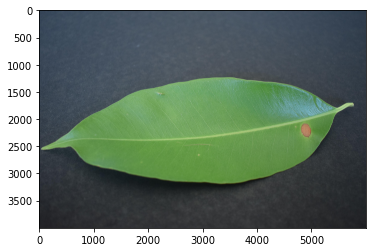

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

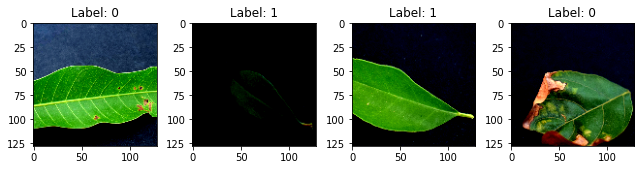

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[03:09:22] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[03:09:24] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2446168436620537 samples/sec                   batch loss = 1.8752858638763428 | accuracy = 0.35


Epoch[1] Batch[10] Speed: 1.2612315406214394 samples/sec                   batch loss = 0.34091195464134216 | accuracy = 0.525


Epoch[1] Batch[15] Speed: 1.2663110645495586 samples/sec                   batch loss = 0.5248897075653076 | accuracy = 0.6166666666666667


Epoch[1] Batch[20] Speed: 1.2692907466816687 samples/sec                   batch loss = 0.9799037575721741 | accuracy = 0.6875


Epoch[1] Batch[25] Speed: 1.2570823581773178 samples/sec                   batch loss = 0.19578403234481812 | accuracy = 0.7


Epoch[1] Batch[30] Speed: 1.2617937501814411 samples/sec                   batch loss = 1.0511541366577148 | accuracy = 0.6666666666666666


Epoch[1] Batch[35] Speed: 1.2690775021408836 samples/sec                   batch loss = 0.34767353534698486 | accuracy = 0.6785714285714286


Epoch[1] Batch[40] Speed: 1.2578435020515324 samples/sec                   batch loss = 1.1738414764404297 | accuracy = 0.65625


Epoch[1] Batch[45] Speed: 1.2628565527237516 samples/sec                   batch loss = 1.2353321313858032 | accuracy = 0.6555555555555556


Epoch[1] Batch[50] Speed: 1.2588503498541466 samples/sec                   batch loss = 0.6002899408340454 | accuracy = 0.66


Epoch[1] Batch[55] Speed: 1.2731551591677677 samples/sec                   batch loss = 1.945542812347412 | accuracy = 0.6454545454545455


Epoch[1] Batch[60] Speed: 1.2700535789621819 samples/sec                   batch loss = 0.5590307116508484 | accuracy = 0.6541666666666667


Epoch[1] Batch[65] Speed: 1.2642455436615372 samples/sec                   batch loss = 1.520095705986023 | accuracy = 0.6653846153846154


Epoch[1] Batch[70] Speed: 1.264258500120569 samples/sec                   batch loss = 0.8336388468742371 | accuracy = 0.6535714285714286


Epoch[1] Batch[75] Speed: 1.2662067012619338 samples/sec                   batch loss = 2.2996163368225098 | accuracy = 0.6533333333333333


Epoch[1] Batch[80] Speed: 1.2751137437433626 samples/sec                   batch loss = 0.3981580138206482 | accuracy = 0.653125


Epoch[1] Batch[85] Speed: 1.267105343155155 samples/sec                   batch loss = 0.9109290242195129 | accuracy = 0.6558823529411765


Epoch[1] Batch[90] Speed: 1.2667606349290723 samples/sec                   batch loss = 0.8393378257751465 | accuracy = 0.6555555555555556


Epoch[1] Batch[95] Speed: 1.2626696965733224 samples/sec                   batch loss = 0.4001389145851135 | accuracy = 0.6605263157894737


Epoch[1] Batch[100] Speed: 1.266899337584116 samples/sec                   batch loss = 0.3740730583667755 | accuracy = 0.66


Epoch[1] Batch[105] Speed: 1.2689435048695656 samples/sec                   batch loss = 0.649186372756958 | accuracy = 0.6595238095238095


Epoch[1] Batch[110] Speed: 1.261810737143847 samples/sec                   batch loss = 0.16676148772239685 | accuracy = 0.6681818181818182


Epoch[1] Batch[115] Speed: 1.266892832229061 samples/sec                   batch loss = 0.5173698663711548 | accuracy = 0.6652173913043479


Epoch[1] Batch[120] Speed: 1.26483895506061 samples/sec                   batch loss = 0.6876014471054077 | accuracy = 0.6666666666666666


Epoch[1] Batch[125] Speed: 1.2718703235089432 samples/sec                   batch loss = 0.39729002118110657 | accuracy = 0.672


Epoch[1] Batch[130] Speed: 1.2741707117667318 samples/sec                   batch loss = 0.5760875344276428 | accuracy = 0.6711538461538461


Epoch[1] Batch[135] Speed: 1.2669614288198787 samples/sec                   batch loss = 0.4379781484603882 | accuracy = 0.6759259259259259


Epoch[1] Batch[140] Speed: 1.2685548233648807 samples/sec                   batch loss = 0.3771219849586487 | accuracy = 0.675


Epoch[1] Batch[145] Speed: 1.2596011537098293 samples/sec                   batch loss = 0.3934522569179535 | accuracy = 0.6741379310344827


Epoch[1] Batch[150] Speed: 1.2625818951834968 samples/sec                   batch loss = 0.38675203919410706 | accuracy = 0.6716666666666666


Epoch[1] Batch[155] Speed: 1.2658031722156726 samples/sec                   batch loss = 0.42331188917160034 | accuracy = 0.6758064516129032


Epoch[1] Batch[160] Speed: 1.2672753266551395 samples/sec                   batch loss = 0.6099517345428467 | accuracy = 0.678125


Epoch[1] Batch[165] Speed: 1.260637624811061 samples/sec                   batch loss = 0.5462587475776672 | accuracy = 0.6742424242424242


Epoch[1] Batch[170] Speed: 1.2627654938360344 samples/sec                   batch loss = 1.1198289394378662 | accuracy = 0.6735294117647059


Epoch[1] Batch[175] Speed: 1.2651335800828596 samples/sec                   batch loss = 0.3863581418991089 | accuracy = 0.6757142857142857


Epoch[1] Batch[180] Speed: 1.2605091919741978 samples/sec                   batch loss = 0.5246422290802002 | accuracy = 0.6722222222222223


Epoch[1] Batch[185] Speed: 1.2693477904614248 samples/sec                   batch loss = 1.111526608467102 | accuracy = 0.668918918918919


Epoch[1] Batch[190] Speed: 1.2587401296672458 samples/sec                   batch loss = 0.520465075969696 | accuracy = 0.6710526315789473


Epoch[1] Batch[195] Speed: 1.2673437732048134 samples/sec                   batch loss = 1.0572882890701294 | accuracy = 0.6692307692307692


Epoch[1] Batch[200] Speed: 1.2684466374689036 samples/sec                   batch loss = 0.573752760887146 | accuracy = 0.6675


Epoch[1] Batch[205] Speed: 1.261741653355891 samples/sec                   batch loss = 0.4811091125011444 | accuracy = 0.6682926829268293


Epoch[1] Batch[210] Speed: 1.2625381890873615 samples/sec                   batch loss = 0.36581090092658997 | accuracy = 0.6726190476190477


Epoch[1] Batch[215] Speed: 1.26766581051024 samples/sec                   batch loss = 1.0385174751281738 | accuracy = 0.6709302325581395


Epoch[1] Batch[220] Speed: 1.2641535223368086 samples/sec                   batch loss = 0.521327018737793 | accuracy = 0.6727272727272727


Epoch[1] Batch[225] Speed: 1.2672616382323918 samples/sec                   batch loss = 0.4631699323654175 | accuracy = 0.6733333333333333


Epoch[1] Batch[230] Speed: 1.2635663684642235 samples/sec                   batch loss = 0.49840378761291504 | accuracy = 0.6728260869565217


Epoch[1] Batch[235] Speed: 1.2668913015669923 samples/sec                   batch loss = 0.6388262510299683 | accuracy = 0.674468085106383


Epoch[1] Batch[240] Speed: 1.262222075097372 samples/sec                   batch loss = 0.26665830612182617 | accuracy = 0.675


Epoch[1] Batch[245] Speed: 1.2667003804808794 samples/sec                   batch loss = 0.6730611324310303 | accuracy = 0.6744897959183673


Epoch[1] Batch[250] Speed: 1.272891938806377 samples/sec                   batch loss = 0.25606459379196167 | accuracy = 0.676


Epoch[1] Batch[255] Speed: 1.2639072454544522 samples/sec                   batch loss = 0.15858404338359833 | accuracy = 0.6764705882352942


Epoch[1] Batch[260] Speed: 1.2619819608932794 samples/sec                   batch loss = 1.3723560571670532 | accuracy = 0.6778846153846154


Epoch[1] Batch[265] Speed: 1.2649128607117182 samples/sec                   batch loss = 0.9219393134117126 | accuracy = 0.680188679245283


Epoch[1] Batch[270] Speed: 1.262815203897583 samples/sec                   batch loss = 0.30980023741722107 | accuracy = 0.6814814814814815


Epoch[1] Batch[275] Speed: 1.2717450866525792 samples/sec                   batch loss = 0.4005465805530548 | accuracy = 0.6845454545454546


Epoch[1] Batch[280] Speed: 1.2635263053647023 samples/sec                   batch loss = 0.38893580436706543 | accuracy = 0.6839285714285714


Epoch[1] Batch[285] Speed: 1.2607301770823292 samples/sec                   batch loss = 0.8023771643638611 | accuracy = 0.6850877192982456


Epoch[1] Batch[290] Speed: 1.2646359735268824 samples/sec                   batch loss = 0.3506510257720947 | accuracy = 0.6836206896551724


Epoch[1] Batch[295] Speed: 1.2649473847623038 samples/sec                   batch loss = 0.3218787908554077 | accuracy = 0.6855932203389831


Epoch[1] Batch[300] Speed: 1.2633549477175678 samples/sec                   batch loss = 0.4400666356086731 | accuracy = 0.6866666666666666


Epoch[1] Batch[305] Speed: 1.2552906786907256 samples/sec                   batch loss = 0.6575159430503845 | accuracy = 0.6877049180327869


Epoch[1] Batch[310] Speed: 1.270439523858997 samples/sec                   batch loss = 0.3795260488986969 | accuracy = 0.6903225806451613


Epoch[1] Batch[315] Speed: 1.2687998443911934 samples/sec                   batch loss = 0.7670323848724365 | accuracy = 0.6904761904761905


Epoch[1] Batch[320] Speed: 1.2716327897401163 samples/sec                   batch loss = 0.5588642954826355 | accuracy = 0.690625


Epoch[1] Batch[325] Speed: 1.26146804959941 samples/sec                   batch loss = 0.5401267409324646 | accuracy = 0.6907692307692308


Epoch[1] Batch[330] Speed: 1.2677427291428516 samples/sec                   batch loss = 0.7808781862258911 | accuracy = 0.6909090909090909


Epoch[1] Batch[335] Speed: 1.2617009468087506 samples/sec                   batch loss = 0.5925838947296143 | accuracy = 0.6902985074626866


Epoch[1] Batch[340] Speed: 1.2656724434813276 samples/sec                   batch loss = 0.42747893929481506 | accuracy = 0.6911764705882353


Epoch[1] Batch[345] Speed: 1.2589700366437584 samples/sec                   batch loss = 0.46387484669685364 | accuracy = 0.6884057971014492


Epoch[1] Batch[350] Speed: 1.2602370690464613 samples/sec                   batch loss = 0.4258236885070801 | accuracy = 0.69


Epoch[1] Batch[355] Speed: 1.2572999761313175 samples/sec                   batch loss = 0.649377703666687 | accuracy = 0.6894366197183098


Epoch[1] Batch[360] Speed: 1.2660968134646913 samples/sec                   batch loss = 1.1472781896591187 | accuracy = 0.6881944444444444


Epoch[1] Batch[365] Speed: 1.264694792376982 samples/sec                   batch loss = 0.7504613399505615 | accuracy = 0.6876712328767123


Epoch[1] Batch[370] Speed: 1.2640918964969425 samples/sec                   batch loss = 0.2516154646873474 | accuracy = 0.6878378378378378


Epoch[1] Batch[375] Speed: 1.2606449186114164 samples/sec                   batch loss = 0.35495275259017944 | accuracy = 0.6893333333333334


Epoch[1] Batch[380] Speed: 1.26760345866859 samples/sec                   batch loss = 0.6565136909484863 | accuracy = 0.6888157894736842


Epoch[1] Batch[385] Speed: 1.2661189805975444 samples/sec                   batch loss = 0.6373130083084106 | accuracy = 0.688961038961039


Epoch[1] Batch[390] Speed: 1.2703446748960499 samples/sec                   batch loss = 0.4693108797073364 | accuracy = 0.691025641025641


Epoch[1] Batch[395] Speed: 1.2617871073596507 samples/sec                   batch loss = 0.7167553305625916 | accuracy = 0.6917721518987342


Epoch[1] Batch[400] Speed: 1.2613972013988646 samples/sec                   batch loss = 0.35791143774986267 | accuracy = 0.69


Epoch[1] Batch[405] Speed: 1.2647560002955105 samples/sec                   batch loss = 1.025189757347107 | accuracy = 0.6882716049382716


Epoch[1] Batch[410] Speed: 1.2695399908272245 samples/sec                   batch loss = 0.2802116274833679 | accuracy = 0.6890243902439024


Epoch[1] Batch[415] Speed: 1.2655416462842684 samples/sec                   batch loss = 0.45549800992012024 | accuracy = 0.6867469879518072


Epoch[1] Batch[420] Speed: 1.2612331524514082 samples/sec                   batch loss = 0.7348540425300598 | accuracy = 0.6857142857142857


Epoch[1] Batch[425] Speed: 1.2607420194487073 samples/sec                   batch loss = 0.7073644399642944 | accuracy = 0.6852941176470588


Epoch[1] Batch[430] Speed: 1.2671628606197711 samples/sec                   batch loss = 0.5973001718521118 | accuracy = 0.6854651162790698


Epoch[1] Batch[435] Speed: 1.2671359674447604 samples/sec                   batch loss = 0.6398921608924866 | accuracy = 0.6827586206896552


Epoch[1] Batch[440] Speed: 1.2642248710378379 samples/sec                   batch loss = 0.7545068264007568 | accuracy = 0.6823863636363636


Epoch[1] Batch[445] Speed: 1.2597721566530575 samples/sec                   batch loss = 0.3960530161857605 | accuracy = 0.6825842696629213


Epoch[1] Batch[450] Speed: 1.2318409871400307 samples/sec                   batch loss = 0.5465890765190125 | accuracy = 0.6844444444444444


Epoch[1] Batch[455] Speed: 1.2744751223410478 samples/sec                   batch loss = 0.8382806181907654 | accuracy = 0.6851648351648352


Epoch[1] Batch[460] Speed: 1.2719036855999493 samples/sec                   batch loss = 0.5918569564819336 | accuracy = 0.6869565217391305


Epoch[1] Batch[465] Speed: 1.2673655053340542 samples/sec                   batch loss = 0.23709887266159058 | accuracy = 0.689247311827957


Epoch[1] Batch[470] Speed: 1.2664820778523542 samples/sec                   batch loss = 0.4618462324142456 | accuracy = 0.6898936170212766


Epoch[1] Batch[475] Speed: 1.272801744467761 samples/sec                   batch loss = 0.5812829732894897 | accuracy = 0.6905263157894737


Epoch[1] Batch[480] Speed: 1.273738978962965 samples/sec                   batch loss = 0.883568286895752 | accuracy = 0.690625


Epoch[1] Batch[485] Speed: 1.2680894098475395 samples/sec                   batch loss = 1.191433310508728 | accuracy = 0.6902061855670103


Epoch[1] Batch[490] Speed: 1.2656385481818326 samples/sec                   batch loss = 0.7249947190284729 | accuracy = 0.6892857142857143


Epoch[1] Batch[495] Speed: 1.2738218590240464 samples/sec                   batch loss = 0.4313633143901825 | accuracy = 0.6888888888888889


Epoch[1] Batch[500] Speed: 1.271468476786431 samples/sec                   batch loss = 0.6104400157928467 | accuracy = 0.6885


Epoch[1] Batch[505] Speed: 1.2691387510041137 samples/sec                   batch loss = 0.409668505191803 | accuracy = 0.689108910891089


Epoch[1] Batch[510] Speed: 1.2696490358979808 samples/sec                   batch loss = 0.8889787197113037 | accuracy = 0.6897058823529412


Epoch[1] Batch[515] Speed: 1.260756325323998 samples/sec                   batch loss = 0.19805003702640533 | accuracy = 0.691747572815534


Epoch[1] Batch[520] Speed: 1.2698332541258832 samples/sec                   batch loss = 0.5461609959602356 | accuracy = 0.6918269230769231


Epoch[1] Batch[525] Speed: 1.2657545635647391 samples/sec                   batch loss = 0.5236434936523438 | accuracy = 0.6928571428571428


Epoch[1] Batch[530] Speed: 1.2693101448328008 samples/sec                   batch loss = 0.6935359835624695 | accuracy = 0.6915094339622642


Epoch[1] Batch[535] Speed: 1.2621124030643276 samples/sec                   batch loss = 0.3560405373573303 | accuracy = 0.6934579439252336


Epoch[1] Batch[540] Speed: 1.2603025799023952 samples/sec                   batch loss = 0.9255051612854004 | accuracy = 0.6935185185185185


Epoch[1] Batch[545] Speed: 1.265954274413882 samples/sec                   batch loss = 0.24461011588573456 | accuracy = 0.6935779816513762


Epoch[1] Batch[550] Speed: 1.2650588855198657 samples/sec                   batch loss = 0.36089959740638733 | accuracy = 0.6931818181818182


Epoch[1] Batch[555] Speed: 1.262265094527218 samples/sec                   batch loss = 0.15648537874221802 | accuracy = 0.6945945945945946


Epoch[1] Batch[560] Speed: 1.2635576133656872 samples/sec                   batch loss = 0.13242197036743164 | accuracy = 0.6950892857142857


Epoch[1] Batch[565] Speed: 1.2700587707833468 samples/sec                   batch loss = 0.38738715648651123 | accuracy = 0.6951327433628318


Epoch[1] Batch[570] Speed: 1.2730288964050693 samples/sec                   batch loss = 0.5584407448768616 | accuracy = 0.6951754385964912


Epoch[1] Batch[575] Speed: 1.269997240817581 samples/sec                   batch loss = 2.0480446815490723 | accuracy = 0.6943478260869566


Epoch[1] Batch[580] Speed: 1.2723965105674593 samples/sec                   batch loss = 0.04935150966048241 | accuracy = 0.6956896551724138


Epoch[1] Batch[585] Speed: 1.2689604929284934 samples/sec                   batch loss = 0.1871289610862732 | accuracy = 0.6965811965811965


Epoch[1] Batch[590] Speed: 1.2736101832845466 samples/sec                   batch loss = 0.2171693742275238 | accuracy = 0.6978813559322034


Epoch[1] Batch[595] Speed: 1.2797541487925217 samples/sec                   batch loss = 0.7516174912452698 | accuracy = 0.6983193277310924


Epoch[1] Batch[600] Speed: 1.275614491256333 samples/sec                   batch loss = 0.4484862685203552 | accuracy = 0.6979166666666666


Epoch[1] Batch[605] Speed: 1.2770263579200685 samples/sec                   batch loss = 1.4385550022125244 | accuracy = 0.697107438016529


Epoch[1] Batch[610] Speed: 1.2710099743869447 samples/sec                   batch loss = 0.6994975209236145 | accuracy = 0.6967213114754098


Epoch[1] Batch[615] Speed: 1.270551802548023 samples/sec                   batch loss = 0.32207444310188293 | accuracy = 0.6963414634146341


Epoch[1] Batch[620] Speed: 1.268417100555444 samples/sec                   batch loss = 0.36357468366622925 | accuracy = 0.6971774193548387


Epoch[1] Batch[625] Speed: 1.2726986257049648 samples/sec                   batch loss = 0.5966029763221741 | accuracy = 0.6968


Epoch[1] Batch[630] Speed: 1.2703727625651855 samples/sec                   batch loss = 0.6400150060653687 | accuracy = 0.696031746031746


Epoch[1] Batch[635] Speed: 1.2732394126766478 samples/sec                   batch loss = 0.18177860975265503 | accuracy = 0.6960629921259842


Epoch[1] Batch[640] Speed: 1.2725748666324272 samples/sec                   batch loss = 0.76059490442276 | accuracy = 0.69609375


Epoch[1] Batch[645] Speed: 1.266753078898213 samples/sec                   batch loss = 0.4612712860107422 | accuracy = 0.6976744186046512


Epoch[1] Batch[650] Speed: 1.2713845538275934 samples/sec                   batch loss = 0.3789655268192291 | accuracy = 0.6973076923076923


Epoch[1] Batch[655] Speed: 1.2620550583518992 samples/sec                   batch loss = 0.6355751156806946 | accuracy = 0.6977099236641221


Epoch[1] Batch[660] Speed: 1.2701194413211918 samples/sec                   batch loss = 0.4856257438659668 | accuracy = 0.6973484848484849


Epoch[1] Batch[665] Speed: 1.2663163213973152 samples/sec                   batch loss = 0.737958550453186 | accuracy = 0.6984962406015037


Epoch[1] Batch[670] Speed: 1.268160244954277 samples/sec                   batch loss = 0.3874100148677826 | accuracy = 0.6988805970149253


Epoch[1] Batch[675] Speed: 1.2712990042819121 samples/sec                   batch loss = 0.3070599436759949 | accuracy = 0.6981481481481482


Epoch[1] Batch[680] Speed: 1.2625239377537132 samples/sec                   batch loss = 0.9104856252670288 | accuracy = 0.6974264705882353


Epoch[1] Batch[685] Speed: 1.264366544464479 samples/sec                   batch loss = 1.2249081134796143 | accuracy = 0.6967153284671533


Epoch[1] Batch[690] Speed: 1.2650819702540281 samples/sec                   batch loss = 0.476323664188385 | accuracy = 0.6971014492753623


Epoch[1] Batch[695] Speed: 1.2665718568140718 samples/sec                   batch loss = 0.47046536207199097 | accuracy = 0.6967625899280575


Epoch[1] Batch[700] Speed: 1.262444136230544 samples/sec                   batch loss = 0.9241264462471008 | accuracy = 0.6960714285714286


Epoch[1] Batch[705] Speed: 1.2641921963340481 samples/sec                   batch loss = 0.7979629039764404 | accuracy = 0.6957446808510638


Epoch[1] Batch[710] Speed: 1.26797785341225 samples/sec                   batch loss = 0.9082245826721191 | accuracy = 0.6961267605633803


Epoch[1] Batch[715] Speed: 1.2735593297021002 samples/sec                   batch loss = 0.7133015394210815 | accuracy = 0.6951048951048951


Epoch[1] Batch[720] Speed: 1.2707978844596985 samples/sec                   batch loss = 0.4978471100330353 | accuracy = 0.69375


Epoch[1] Batch[725] Speed: 1.2619915485189899 samples/sec                   batch loss = 0.38493433594703674 | accuracy = 0.6948275862068966


Epoch[1] Batch[730] Speed: 1.265458503874243 samples/sec                   batch loss = 0.8272926807403564 | accuracy = 0.6945205479452055


Epoch[1] Batch[735] Speed: 1.2708299389044462 samples/sec                   batch loss = 0.45724353194236755 | accuracy = 0.6945578231292517


Epoch[1] Batch[740] Speed: 1.2704199949735118 samples/sec                   batch loss = 0.42315593361854553 | accuracy = 0.6945945945945946


Epoch[1] Batch[745] Speed: 1.2604944181935605 samples/sec                   batch loss = 0.3505874276161194 | accuracy = 0.6956375838926174


Epoch[1] Batch[750] Speed: 1.2650244507672652 samples/sec                   batch loss = 0.36146605014801025 | accuracy = 0.6973333333333334


Epoch[1] Batch[755] Speed: 1.272216660932653 samples/sec                   batch loss = 0.5835290551185608 | accuracy = 0.6983443708609272


Epoch[1] Batch[760] Speed: 1.2706557285295688 samples/sec                   batch loss = 0.49696388840675354 | accuracy = 0.6980263157894737


Epoch[1] Batch[765] Speed: 1.2691651531995833 samples/sec                   batch loss = 0.4594421982765198 | accuracy = 0.6983660130718954


Epoch[1] Batch[770] Speed: 1.2672587665728376 samples/sec                   batch loss = 0.5332265496253967 | accuracy = 0.6974025974025974


Epoch[1] Batch[775] Speed: 1.2637374979012677 samples/sec                   batch loss = 0.23290058970451355 | accuracy = 0.697741935483871


Epoch[1] Batch[780] Speed: 1.2674841356877296 samples/sec                   batch loss = 0.27306005358695984 | accuracy = 0.6983974358974359


Epoch[1] Batch[785] Speed: 1.263552093909399 samples/sec                   batch loss = 2.427229404449463 | accuracy = 0.6980891719745222


[Epoch 1] training: accuracy=0.6976522842639594
[Epoch 1] time cost: 649.0724864006042
[Epoch 1] validation: validation accuracy=0.7577777777777778


Epoch[2] Batch[5] Speed: 1.2638150829646217 samples/sec                   batch loss = 0.5074734687805176 | accuracy = 0.75


Epoch[2] Batch[10] Speed: 1.2595997351848969 samples/sec                   batch loss = 0.528876543045044 | accuracy = 0.7


Epoch[2] Batch[15] Speed: 1.2656350155367768 samples/sec                   batch loss = 0.8670519590377808 | accuracy = 0.65


Epoch[2] Batch[20] Speed: 1.2721909033720624 samples/sec                   batch loss = 0.28641167283058167 | accuracy = 0.6875


Epoch[2] Batch[25] Speed: 1.263524021559086 samples/sec                   batch loss = 0.9011356830596924 | accuracy = 0.69


Epoch[2] Batch[30] Speed: 1.2712056643655643 samples/sec                   batch loss = 0.294078528881073 | accuracy = 0.6916666666666667


Epoch[2] Batch[35] Speed: 1.27266792503182 samples/sec                   batch loss = 0.36079099774360657 | accuracy = 0.7


Epoch[2] Batch[40] Speed: 1.2708844255448344 samples/sec                   batch loss = 0.6880871057510376 | accuracy = 0.70625


Epoch[2] Batch[45] Speed: 1.271351797010691 samples/sec                   batch loss = 0.7498783469200134 | accuracy = 0.7


Epoch[2] Batch[50] Speed: 1.2697512766599304 samples/sec                   batch loss = 0.5104360580444336 | accuracy = 0.71


Epoch[2] Batch[55] Speed: 1.2761128173564322 samples/sec                   batch loss = 0.5764199495315552 | accuracy = 0.7181818181818181


Epoch[2] Batch[60] Speed: 1.27149497600356 samples/sec                   batch loss = 0.28870320320129395 | accuracy = 0.7291666666666666


Epoch[2] Batch[65] Speed: 1.2747908175515699 samples/sec                   batch loss = 0.43050137162208557 | accuracy = 0.7346153846153847


Epoch[2] Batch[70] Speed: 1.26318753594715 samples/sec                   batch loss = 0.39500293135643005 | accuracy = 0.7392857142857143


Epoch[2] Batch[75] Speed: 1.2680780041221642 samples/sec                   batch loss = 0.7462387681007385 | accuracy = 0.7433333333333333


Epoch[2] Batch[80] Speed: 1.2670322336493056 samples/sec                   batch loss = 0.6837052702903748 | accuracy = 0.74375


Epoch[2] Batch[85] Speed: 1.274065145756583 samples/sec                   batch loss = 0.9833530783653259 | accuracy = 0.7441176470588236


Epoch[2] Batch[90] Speed: 1.2792340523648864 samples/sec                   batch loss = 0.15793141722679138 | accuracy = 0.7472222222222222


Epoch[2] Batch[95] Speed: 1.2677903409932012 samples/sec                   batch loss = 0.5411453247070312 | accuracy = 0.7447368421052631


Epoch[2] Batch[100] Speed: 1.2769683303448738 samples/sec                   batch loss = 0.4761221706867218 | accuracy = 0.745


Epoch[2] Batch[105] Speed: 1.2682849684803832 samples/sec                   batch loss = 0.5576117038726807 | accuracy = 0.7428571428571429


Epoch[2] Batch[110] Speed: 1.2652317553169667 samples/sec                   batch loss = 0.40133729577064514 | accuracy = 0.75


Epoch[2] Batch[115] Speed: 1.26683237388962 samples/sec                   batch loss = 0.9026317000389099 | accuracy = 0.7521739130434782


Epoch[2] Batch[120] Speed: 1.2618020063574389 samples/sec                   batch loss = 0.650052011013031 | accuracy = 0.7479166666666667


Epoch[2] Batch[125] Speed: 1.266625118293955 samples/sec                   batch loss = 0.35700899362564087 | accuracy = 0.746


Epoch[2] Batch[130] Speed: 1.2662184556077163 samples/sec                   batch loss = 0.920274555683136 | accuracy = 0.7461538461538462


Epoch[2] Batch[135] Speed: 1.2704759857989012 samples/sec                   batch loss = 0.2993255853652954 | accuracy = 0.7388888888888889


Epoch[2] Batch[140] Speed: 1.2594320880427556 samples/sec                   batch loss = 0.494558185338974 | accuracy = 0.7410714285714286


Epoch[2] Batch[145] Speed: 1.2639041985457415 samples/sec                   batch loss = 0.5238178372383118 | accuracy = 0.7448275862068966


Epoch[2] Batch[150] Speed: 1.2707281980931975 samples/sec                   batch loss = 1.0814753770828247 | accuracy = 0.735


Epoch[2] Batch[155] Speed: 1.269813167226118 samples/sec                   batch loss = 0.45010554790496826 | accuracy = 0.7354838709677419


Epoch[2] Batch[160] Speed: 1.2710118038862446 samples/sec                   batch loss = 1.0271373987197876 | accuracy = 0.728125


Epoch[2] Batch[165] Speed: 1.263120773856861 samples/sec                   batch loss = 0.2586990296840668 | accuracy = 0.7287878787878788


Epoch[2] Batch[170] Speed: 1.261818803738672 samples/sec                   batch loss = 1.2046923637390137 | accuracy = 0.725


Epoch[2] Batch[175] Speed: 1.269198469537473 samples/sec                   batch loss = 0.8077337145805359 | accuracy = 0.7242857142857143


Epoch[2] Batch[180] Speed: 1.267192530571372 samples/sec                   batch loss = 0.26019296050071716 | accuracy = 0.725


Epoch[2] Batch[185] Speed: 1.2697433005196292 samples/sec                   batch loss = 0.6979469060897827 | accuracy = 0.7283783783783784


Epoch[2] Batch[190] Speed: 1.2634899557720196 samples/sec                   batch loss = 0.5121196508407593 | accuracy = 0.7289473684210527


Epoch[2] Batch[195] Speed: 1.2603693284579947 samples/sec                   batch loss = 0.2334122210741043 | accuracy = 0.7333333333333333


Epoch[2] Batch[200] Speed: 1.2637787167549575 samples/sec                   batch loss = 0.35647308826446533 | accuracy = 0.735


Epoch[2] Batch[205] Speed: 1.2633245059133473 samples/sec                   batch loss = 0.31874987483024597 | accuracy = 0.7341463414634146


Epoch[2] Batch[210] Speed: 1.2596477776741661 samples/sec                   batch loss = 0.5465737581253052 | accuracy = 0.7321428571428571


Epoch[2] Batch[215] Speed: 1.2601972167854576 samples/sec                   batch loss = 1.1517906188964844 | accuracy = 0.7313953488372092


Epoch[2] Batch[220] Speed: 1.270748410202637 samples/sec                   batch loss = 0.5751124024391174 | accuracy = 0.7306818181818182


Epoch[2] Batch[225] Speed: 1.2681327343044801 samples/sec                   batch loss = 0.24019528925418854 | accuracy = 0.7344444444444445


Epoch[2] Batch[230] Speed: 1.2645913625534573 samples/sec                   batch loss = 0.4560600817203522 | accuracy = 0.7326086956521739


Epoch[2] Batch[235] Speed: 1.2578032352348907 samples/sec                   batch loss = 0.4895561933517456 | accuracy = 0.7308510638297873


Epoch[2] Batch[240] Speed: 1.27107400999633 samples/sec                   batch loss = 0.677343487739563 | accuracy = 0.73125


Epoch[2] Batch[245] Speed: 1.2635448615913893 samples/sec                   batch loss = 0.3524486720561981 | accuracy = 0.7316326530612245


Epoch[2] Batch[250] Speed: 1.2678959236881127 samples/sec                   batch loss = 0.604022741317749 | accuracy = 0.732


Epoch[2] Batch[255] Speed: 1.271338887434799 samples/sec                   batch loss = 0.7853714823722839 | accuracy = 0.7284313725490196


Epoch[2] Batch[260] Speed: 1.263114307248656 samples/sec                   batch loss = 0.3219252824783325 | accuracy = 0.7317307692307692


Epoch[2] Batch[265] Speed: 1.2712515138397324 samples/sec                   batch loss = 0.21512682735919952 | accuracy = 0.7339622641509433


Epoch[2] Batch[270] Speed: 1.268762519103603 samples/sec                   batch loss = 0.4932132661342621 | accuracy = 0.7333333333333333


Epoch[2] Batch[275] Speed: 1.2594512805745373 samples/sec                   batch loss = 0.3671984374523163 | accuracy = 0.7354545454545455


Epoch[2] Batch[280] Speed: 1.2508340712465973 samples/sec                   batch loss = 0.4999605119228363 | accuracy = 0.7375


Epoch[2] Batch[285] Speed: 1.2551801418798403 samples/sec                   batch loss = 0.49668145179748535 | accuracy = 0.737719298245614


Epoch[2] Batch[290] Speed: 1.2670923282803104 samples/sec                   batch loss = 0.7004610896110535 | accuracy = 0.7336206896551725


Epoch[2] Batch[295] Speed: 1.26571608038495 samples/sec                   batch loss = 0.4343191087245941 | accuracy = 0.7330508474576272


Epoch[2] Batch[300] Speed: 1.2691519999685308 samples/sec                   batch loss = 0.7634533047676086 | accuracy = 0.7316666666666667


Epoch[2] Batch[305] Speed: 1.261007346774585 samples/sec                   batch loss = 0.44341200590133667 | accuracy = 0.7344262295081967


Epoch[2] Batch[310] Speed: 1.2648696606179077 samples/sec                   batch loss = 0.286854088306427 | accuracy = 0.7346774193548387


Epoch[2] Batch[315] Speed: 1.269414155923091 samples/sec                   batch loss = 0.23394927382469177 | accuracy = 0.7373015873015873


Epoch[2] Batch[320] Speed: 1.268544943922597 samples/sec                   batch loss = 0.46633628010749817 | accuracy = 0.73671875


Epoch[2] Batch[325] Speed: 1.2611286764656138 samples/sec                   batch loss = 0.2300800383090973 | accuracy = 0.7361538461538462


Epoch[2] Batch[330] Speed: 1.2636160464292516 samples/sec                   batch loss = 0.34608039259910583 | accuracy = 0.7378787878787879


Epoch[2] Batch[335] Speed: 1.2633958562022962 samples/sec                   batch loss = 1.1871486902236938 | accuracy = 0.7350746268656716


Epoch[2] Batch[340] Speed: 1.269120990145206 samples/sec                   batch loss = 0.5126537084579468 | accuracy = 0.7338235294117647


Epoch[2] Batch[345] Speed: 1.2661126743514397 samples/sec                   batch loss = 0.3507305979728699 | accuracy = 0.7355072463768116


Epoch[2] Batch[350] Speed: 1.2569757434600755 samples/sec                   batch loss = 0.2931073307991028 | accuracy = 0.7342857142857143


Epoch[2] Batch[355] Speed: 1.2660297435056913 samples/sec                   batch loss = 0.2535993456840515 | accuracy = 0.7338028169014085


Epoch[2] Batch[360] Speed: 1.259524557935244 samples/sec                   batch loss = 0.5827330350875854 | accuracy = 0.7347222222222223


Epoch[2] Batch[365] Speed: 1.2668019555781607 samples/sec                   batch loss = 0.388164222240448 | accuracy = 0.7356164383561644


Epoch[2] Batch[370] Speed: 1.2631758378060038 samples/sec                   batch loss = 0.47740650177001953 | accuracy = 0.7364864864864865


Epoch[2] Batch[375] Speed: 1.2473046908222991 samples/sec                   batch loss = 0.4029986262321472 | accuracy = 0.738


Epoch[2] Batch[380] Speed: 1.261406116263501 samples/sec                   batch loss = 0.15568940341472626 | accuracy = 0.7361842105263158


Epoch[2] Batch[385] Speed: 1.2572038757979194 samples/sec                   batch loss = 1.6258121728897095 | accuracy = 0.7363636363636363


Epoch[2] Batch[390] Speed: 1.2557567062397963 samples/sec                   batch loss = 0.426577627658844 | accuracy = 0.735897435897436


Epoch[2] Batch[395] Speed: 1.2515814094846822 samples/sec                   batch loss = 0.4879539906978607 | accuracy = 0.7348101265822785


Epoch[2] Batch[400] Speed: 1.2549165098945045 samples/sec                   batch loss = 0.6178950667381287 | accuracy = 0.735


Epoch[2] Batch[405] Speed: 1.26142451542509 samples/sec                   batch loss = 0.37615007162094116 | accuracy = 0.7351851851851852


Epoch[2] Batch[410] Speed: 1.2623196090102442 samples/sec                   batch loss = 0.353115439414978 | accuracy = 0.7347560975609756


Epoch[2] Batch[415] Speed: 1.2594163940918917 samples/sec                   batch loss = 0.19247446954250336 | accuracy = 0.7367469879518073


Epoch[2] Batch[420] Speed: 1.2493581641902234 samples/sec                   batch loss = 0.8666377067565918 | accuracy = 0.7363095238095239


Epoch[2] Batch[425] Speed: 1.2584138324279701 samples/sec                   batch loss = 0.25959447026252747 | accuracy = 0.7358823529411764


Epoch[2] Batch[430] Speed: 1.2636068147877677 samples/sec                   batch loss = 0.5616127252578735 | accuracy = 0.7348837209302326


Epoch[2] Batch[435] Speed: 1.2570540074458718 samples/sec                   batch loss = 0.3313429653644562 | accuracy = 0.7344827586206897


Epoch[2] Batch[440] Speed: 1.2559863708105847 samples/sec                   batch loss = 0.47557249665260315 | accuracy = 0.7346590909090909


Epoch[2] Batch[445] Speed: 1.2543032994473198 samples/sec                   batch loss = 0.5443102121353149 | accuracy = 0.7353932584269663


Epoch[2] Batch[450] Speed: 1.2607201349299595 samples/sec                   batch loss = 0.1485726237297058 | accuracy = 0.7366666666666667


Epoch[2] Batch[455] Speed: 1.2593664785835765 samples/sec                   batch loss = 1.0686240196228027 | accuracy = 0.7335164835164835


Epoch[2] Batch[460] Speed: 1.2727490243609538 samples/sec                   batch loss = 0.6175336837768555 | accuracy = 0.7326086956521739


Epoch[2] Batch[465] Speed: 1.2624915409189257 samples/sec                   batch loss = 1.6954363584518433 | accuracy = 0.7322580645161291


Epoch[2] Batch[470] Speed: 1.2649503413293772 samples/sec                   batch loss = 0.33960485458374023 | accuracy = 0.7313829787234043


Epoch[2] Batch[475] Speed: 1.2717393026361739 samples/sec                   batch loss = 0.7203763127326965 | accuracy = 0.7305263157894737


Epoch[2] Batch[480] Speed: 1.2708070289562572 samples/sec                   batch loss = 0.3996654748916626 | accuracy = 0.7302083333333333


Epoch[2] Batch[485] Speed: 1.2637991843903489 samples/sec                   batch loss = 0.5932167172431946 | accuracy = 0.7298969072164948


Epoch[2] Batch[490] Speed: 1.2578606657406337 samples/sec                   batch loss = 0.29759538173675537 | accuracy = 0.7301020408163266


Epoch[2] Batch[495] Speed: 1.262139843023331 samples/sec                   batch loss = 0.5236044526100159 | accuracy = 0.7308080808080808


Epoch[2] Batch[500] Speed: 1.272763893692469 samples/sec                   batch loss = 0.587466835975647 | accuracy = 0.731


Epoch[2] Batch[505] Speed: 1.2658411831527965 samples/sec                   batch loss = 0.3914206027984619 | accuracy = 0.7301980198019802


Epoch[2] Batch[510] Speed: 1.2590765175008782 samples/sec                   batch loss = 0.28344544768333435 | accuracy = 0.7318627450980392


Epoch[2] Batch[515] Speed: 1.2553363265876616 samples/sec                   batch loss = 0.30002859234809875 | accuracy = 0.7320388349514563


Epoch[2] Batch[520] Speed: 1.2605731209779223 samples/sec                   batch loss = 0.170366570353508 | accuracy = 0.7336538461538461


Epoch[2] Batch[525] Speed: 1.27611582634795 samples/sec                   batch loss = 0.3718472421169281 | accuracy = 0.7338095238095238


Epoch[2] Batch[530] Speed: 1.2643515848428375 samples/sec                   batch loss = 0.10112035274505615 | accuracy = 0.7330188679245283


Epoch[2] Batch[535] Speed: 1.2594698118499292 samples/sec                   batch loss = 0.465765118598938 | accuracy = 0.7341121495327103


Epoch[2] Batch[540] Speed: 1.2663597159532172 samples/sec                   batch loss = 1.0997543334960938 | accuracy = 0.7337962962962963


Epoch[2] Batch[545] Speed: 1.2700888649532207 samples/sec                   batch loss = 0.2935171127319336 | accuracy = 0.7353211009174312


Epoch[2] Batch[550] Speed: 1.2653896881684608 samples/sec                   batch loss = 0.17919278144836426 | accuracy = 0.7368181818181818


Epoch[2] Batch[555] Speed: 1.267792161235515 samples/sec                   batch loss = 0.6338077187538147 | accuracy = 0.736936936936937


Epoch[2] Batch[560] Speed: 1.2637720530167282 samples/sec                   batch loss = 0.19084268808364868 | accuracy = 0.7379464285714286


Epoch[2] Batch[565] Speed: 1.2639645681624254 samples/sec                   batch loss = 0.447196900844574 | accuracy = 0.736283185840708


Epoch[2] Batch[570] Speed: 1.263604340350087 samples/sec                   batch loss = 0.3905840516090393 | accuracy = 0.7364035087719298


Epoch[2] Batch[575] Speed: 1.261220542362204 samples/sec                   batch loss = 0.2749581038951874 | accuracy = 0.7369565217391304


Epoch[2] Batch[580] Speed: 1.2546468899112193 samples/sec                   batch loss = 0.3394322395324707 | accuracy = 0.7366379310344827


Epoch[2] Batch[585] Speed: 1.261636428991471 samples/sec                   batch loss = 0.33653801679611206 | accuracy = 0.7367521367521368


Epoch[2] Batch[590] Speed: 1.2655595934963582 samples/sec                   batch loss = 0.7634304761886597 | accuracy = 0.7364406779661017


Epoch[2] Batch[595] Speed: 1.2703204358512719 samples/sec                   batch loss = 0.30496954917907715 | accuracy = 0.7365546218487395


Epoch[2] Batch[600] Speed: 1.2668150601433037 samples/sec                   batch loss = 0.41870200634002686 | accuracy = 0.7375


Epoch[2] Batch[605] Speed: 1.2621007248278202 samples/sec                   batch loss = 0.4678691029548645 | accuracy = 0.7371900826446282


Epoch[2] Batch[610] Speed: 1.261348835712651 samples/sec                   batch loss = 0.4776463508605957 | accuracy = 0.7372950819672132


Epoch[2] Batch[615] Speed: 1.2744412379779664 samples/sec                   batch loss = 0.09384158253669739 | accuracy = 0.7390243902439024


Epoch[2] Batch[620] Speed: 1.2676291265794914 samples/sec                   batch loss = 0.9937638640403748 | accuracy = 0.7379032258064516


Epoch[2] Batch[625] Speed: 1.2665045453015076 samples/sec                   batch loss = 0.3599931001663208 | accuracy = 0.7368


Epoch[2] Batch[630] Speed: 1.2616349110046357 samples/sec                   batch loss = 0.7583152651786804 | accuracy = 0.7373015873015873


Epoch[2] Batch[635] Speed: 1.2692295791669583 samples/sec                   batch loss = 0.43390142917633057 | accuracy = 0.7377952755905511


Epoch[2] Batch[640] Speed: 1.266591650054677 samples/sec                   batch loss = 0.5145575404167175 | accuracy = 0.7375


Epoch[2] Batch[645] Speed: 1.2727470933044291 samples/sec                   batch loss = 1.0576460361480713 | accuracy = 0.7375968992248062


Epoch[2] Batch[650] Speed: 1.2643837913465774 samples/sec                   batch loss = 0.19517824053764343 | accuracy = 0.7384615384615385


Epoch[2] Batch[655] Speed: 1.2669819996776892 samples/sec                   batch loss = 0.5249499082565308 | accuracy = 0.7389312977099237


Epoch[2] Batch[660] Speed: 1.2717787313910853 samples/sec                   batch loss = 0.3464459180831909 | accuracy = 0.7401515151515151


Epoch[2] Batch[665] Speed: 1.2677467525411659 samples/sec                   batch loss = 0.508730411529541 | accuracy = 0.7390977443609023


Epoch[2] Batch[670] Speed: 1.2675408256671408 samples/sec                   batch loss = 0.8732706308364868 | accuracy = 0.7384328358208955


Epoch[2] Batch[675] Speed: 1.2587305913811864 samples/sec                   batch loss = 0.2630118429660797 | accuracy = 0.74


Epoch[2] Batch[680] Speed: 1.2604544549583223 samples/sec                   batch loss = 0.2660941183567047 | accuracy = 0.7408088235294118


Epoch[2] Batch[685] Speed: 1.2630698035645709 samples/sec                   batch loss = 0.27089712023735046 | accuracy = 0.7416058394160584


Epoch[2] Batch[690] Speed: 1.2642716473872182 samples/sec                   batch loss = 0.5135528445243835 | accuracy = 0.7420289855072464


Epoch[2] Batch[695] Speed: 1.2713374423493364 samples/sec                   batch loss = 0.9224730730056763 | accuracy = 0.7413669064748202


Epoch[2] Batch[700] Speed: 1.2612550547846146 samples/sec                   batch loss = 0.23506517708301544 | accuracy = 0.7421428571428571


Epoch[2] Batch[705] Speed: 1.2730769061495568 samples/sec                   batch loss = 0.5389541387557983 | accuracy = 0.7418439716312056


Epoch[2] Batch[710] Speed: 1.2617511424390178 samples/sec                   batch loss = 1.2252330780029297 | accuracy = 0.7419014084507042


Epoch[2] Batch[715] Speed: 1.262728617772144 samples/sec                   batch loss = 0.9671638607978821 | accuracy = 0.7426573426573426


Epoch[2] Batch[720] Speed: 1.2612023387684037 samples/sec                   batch loss = 0.8506577610969543 | accuracy = 0.7434027777777777


Epoch[2] Batch[725] Speed: 1.2568602959745403 samples/sec                   batch loss = 0.41852259635925293 | accuracy = 0.743103448275862


Epoch[2] Batch[730] Speed: 1.2614978328788407 samples/sec                   batch loss = 0.7045360803604126 | accuracy = 0.7438356164383562


Epoch[2] Batch[735] Speed: 1.2638183198491122 samples/sec                   batch loss = 0.29021838307380676 | accuracy = 0.7445578231292517


Epoch[2] Batch[740] Speed: 1.266593944963174 samples/sec                   batch loss = 0.6311370134353638 | accuracy = 0.7439189189189189


Epoch[2] Batch[745] Speed: 1.2634969019985014 samples/sec                   batch loss = 1.1899023056030273 | accuracy = 0.7442953020134229


Epoch[2] Batch[750] Speed: 1.2636128105808002 samples/sec                   batch loss = 1.1807630062103271 | accuracy = 0.7443333333333333


Epoch[2] Batch[755] Speed: 1.2701265567877877 samples/sec                   batch loss = 0.6586565971374512 | accuracy = 0.7440397350993377


Epoch[2] Batch[760] Speed: 1.272291527778968 samples/sec                   batch loss = 0.29070016741752625 | accuracy = 0.7447368421052631


Epoch[2] Batch[765] Speed: 1.268735557986904 samples/sec                   batch loss = 0.317349374294281 | accuracy = 0.7457516339869281


Epoch[2] Batch[770] Speed: 1.2596351046931973 samples/sec                   batch loss = 0.3749556541442871 | accuracy = 0.7461038961038962


Epoch[2] Batch[775] Speed: 1.264736264384899 samples/sec                   batch loss = 0.32535263895988464 | accuracy = 0.7467741935483871


Epoch[2] Batch[780] Speed: 1.2698854445919412 samples/sec                   batch loss = 0.07037078589200974 | accuracy = 0.7480769230769231


Epoch[2] Batch[785] Speed: 1.269906687243881 samples/sec                   batch loss = 0.6170006394386292 | accuracy = 0.7487261146496815


[Epoch 2] training: accuracy=0.7490482233502538
[Epoch 2] time cost: 641.4285659790039
[Epoch 2] validation: validation accuracy=0.7411111111111112


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7688888888888888

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)